In [109]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/90+_DaysPastDue/90+DPD_files")

train = pd.read_csv("FITB_train.csv", na_values=["", "NA"])

test = pd.read_csv("FITB_test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

remove upper and lower 1% of feature 3 for train but not test 

In [110]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

replace na with median value for both

In [111]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

replace na of feature 2 with forward fill and backward fill 

In [112]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

replace y with 1 if 90+DPD and 0 if active 

In [113]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

Standardize features

In [114]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

Logistic Regression Model 

86% recall with interaction term 1 and 2 and 2 and 3 

86.4% recall with interaction term for only feature 2 and 4 

86% recall with interaction term 1 and 2 - 93% ROC

1x2 
2x3 
2x4 



holy shit 96% ROC and 90.7 % recall

lastly lets add 1 and 4 - 96% roc and 90.2% recall

lastly lets try 
1x2 
2x3 
2x4 
and 3x4 

BEST ONE 

96 and 91.1%

1x2 
2x3 
2x4 
and 3x4 
and 1x4



In [115]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']
train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']
train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']
train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']
train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

In [116]:
from sklearn.linear_model import LogisticRegression
X_train = train[['feature_1', 'feature_2', 'feature_3', 'feature_4', 
                 'feature_1_x_feature_2', 'feature_2_x_feature_3', 'feature_2_x_feature_4',
                 'feature_3_x_feature_4', 'feature_1_x_feature_4']]
y_train = train['y']

model = LogisticRegression(fit_intercept=True)
model.fit(X_train, y_train);

ROC Curve 

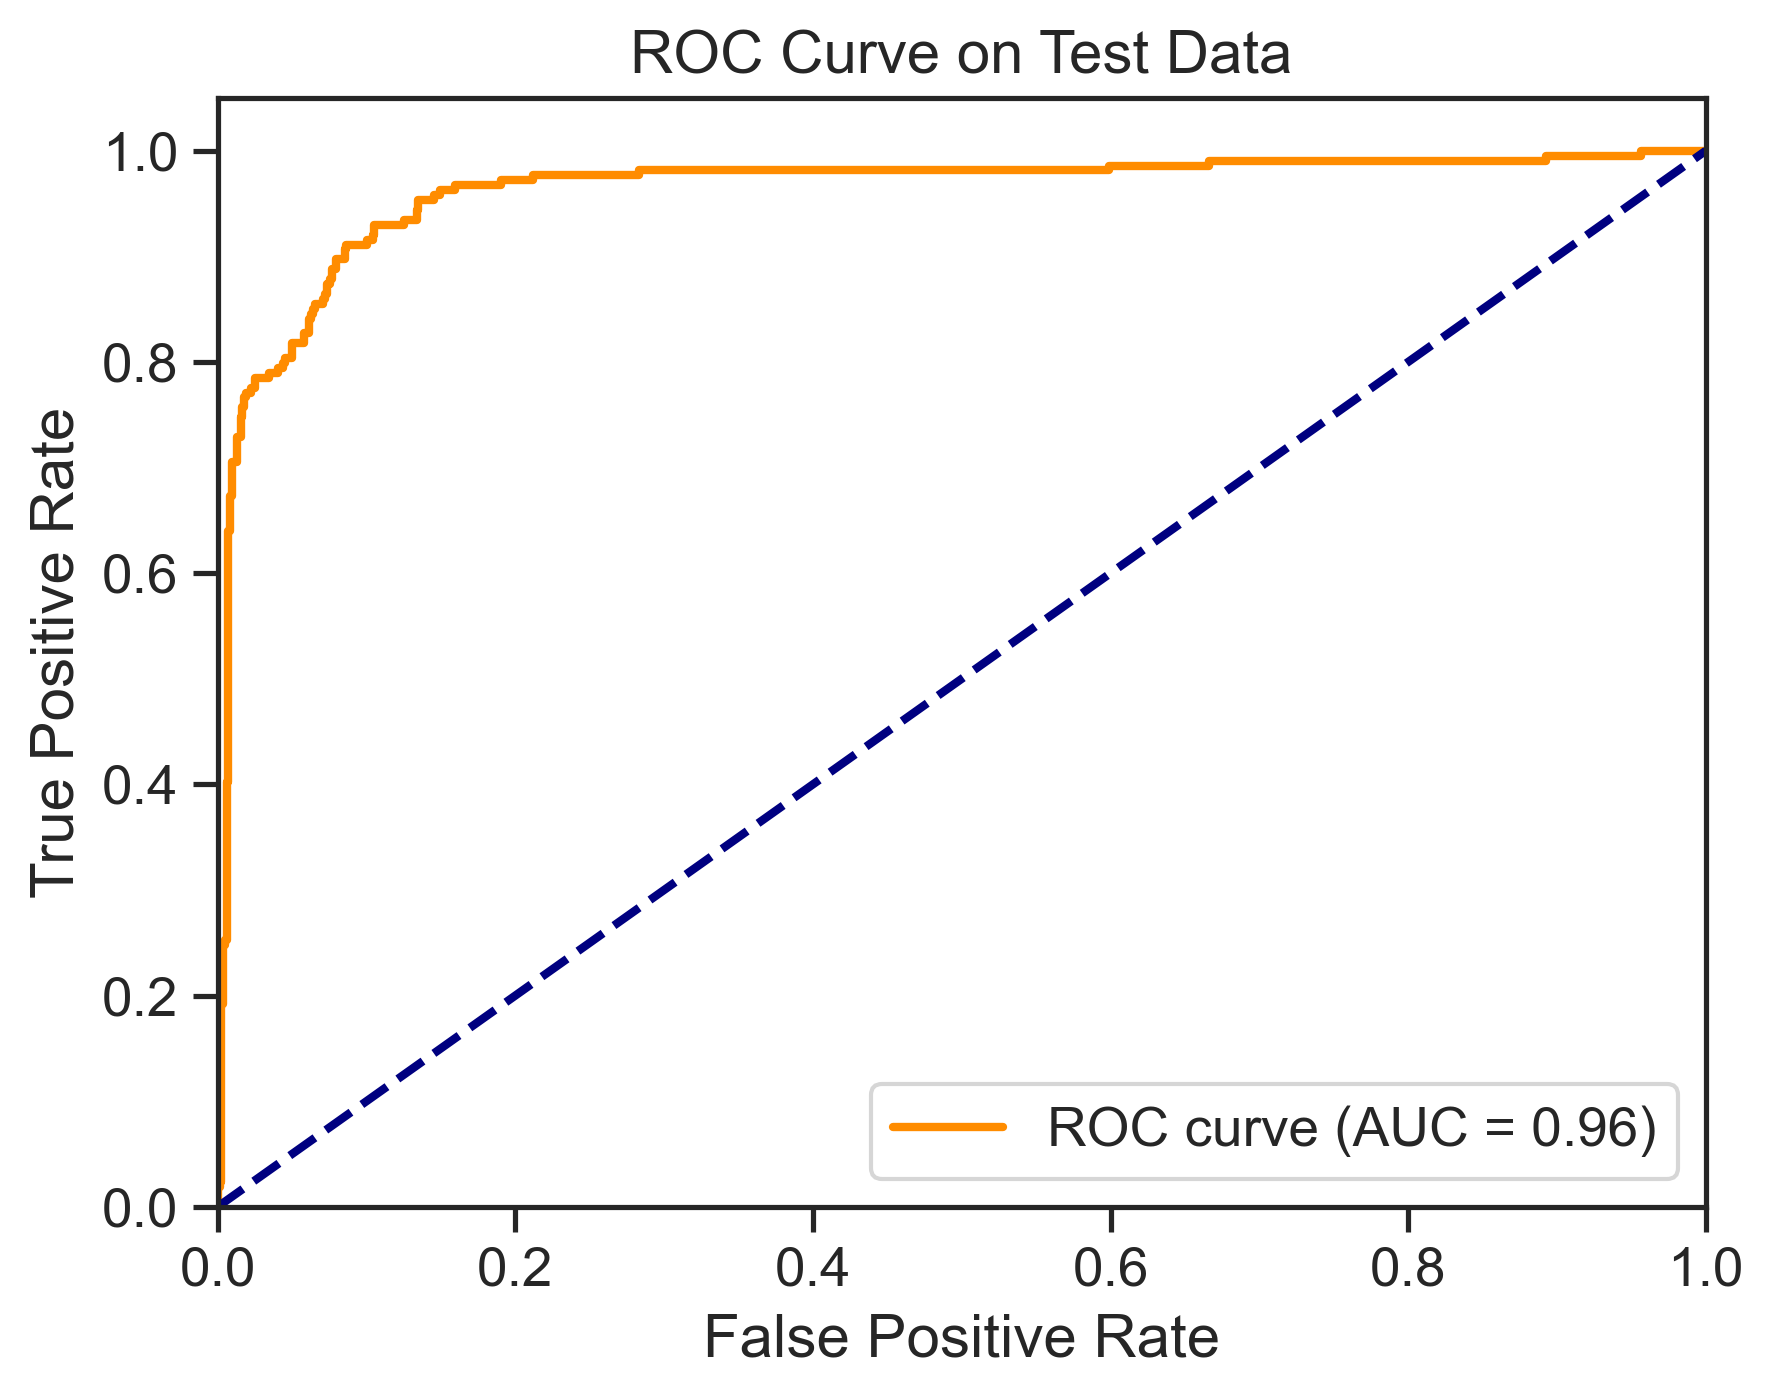

In [117]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X_test = test[['feature_1', 'feature_2', 'feature_3', 'feature_4', 
               'feature_1_x_feature_2', 'feature_2_x_feature_3', 'feature_2_x_feature_4',
                 'feature_3_x_feature_4', 'feature_1_x_feature_4']]
y_test = test['y']
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Data')
plt.legend(loc="lower right")
plt.show()

optimal threshold 

In [118]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.307


In [119]:
from sklearn.metrics import confusion_matrix, recall_score

y_pred = (y_pred_proba >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nRecall at optimal threshold: {recall:.3f}")

Confusion Matrix:
[[772  73]
 [ 19 195]]

Recall at optimal threshold: 0.911


# EDA for features

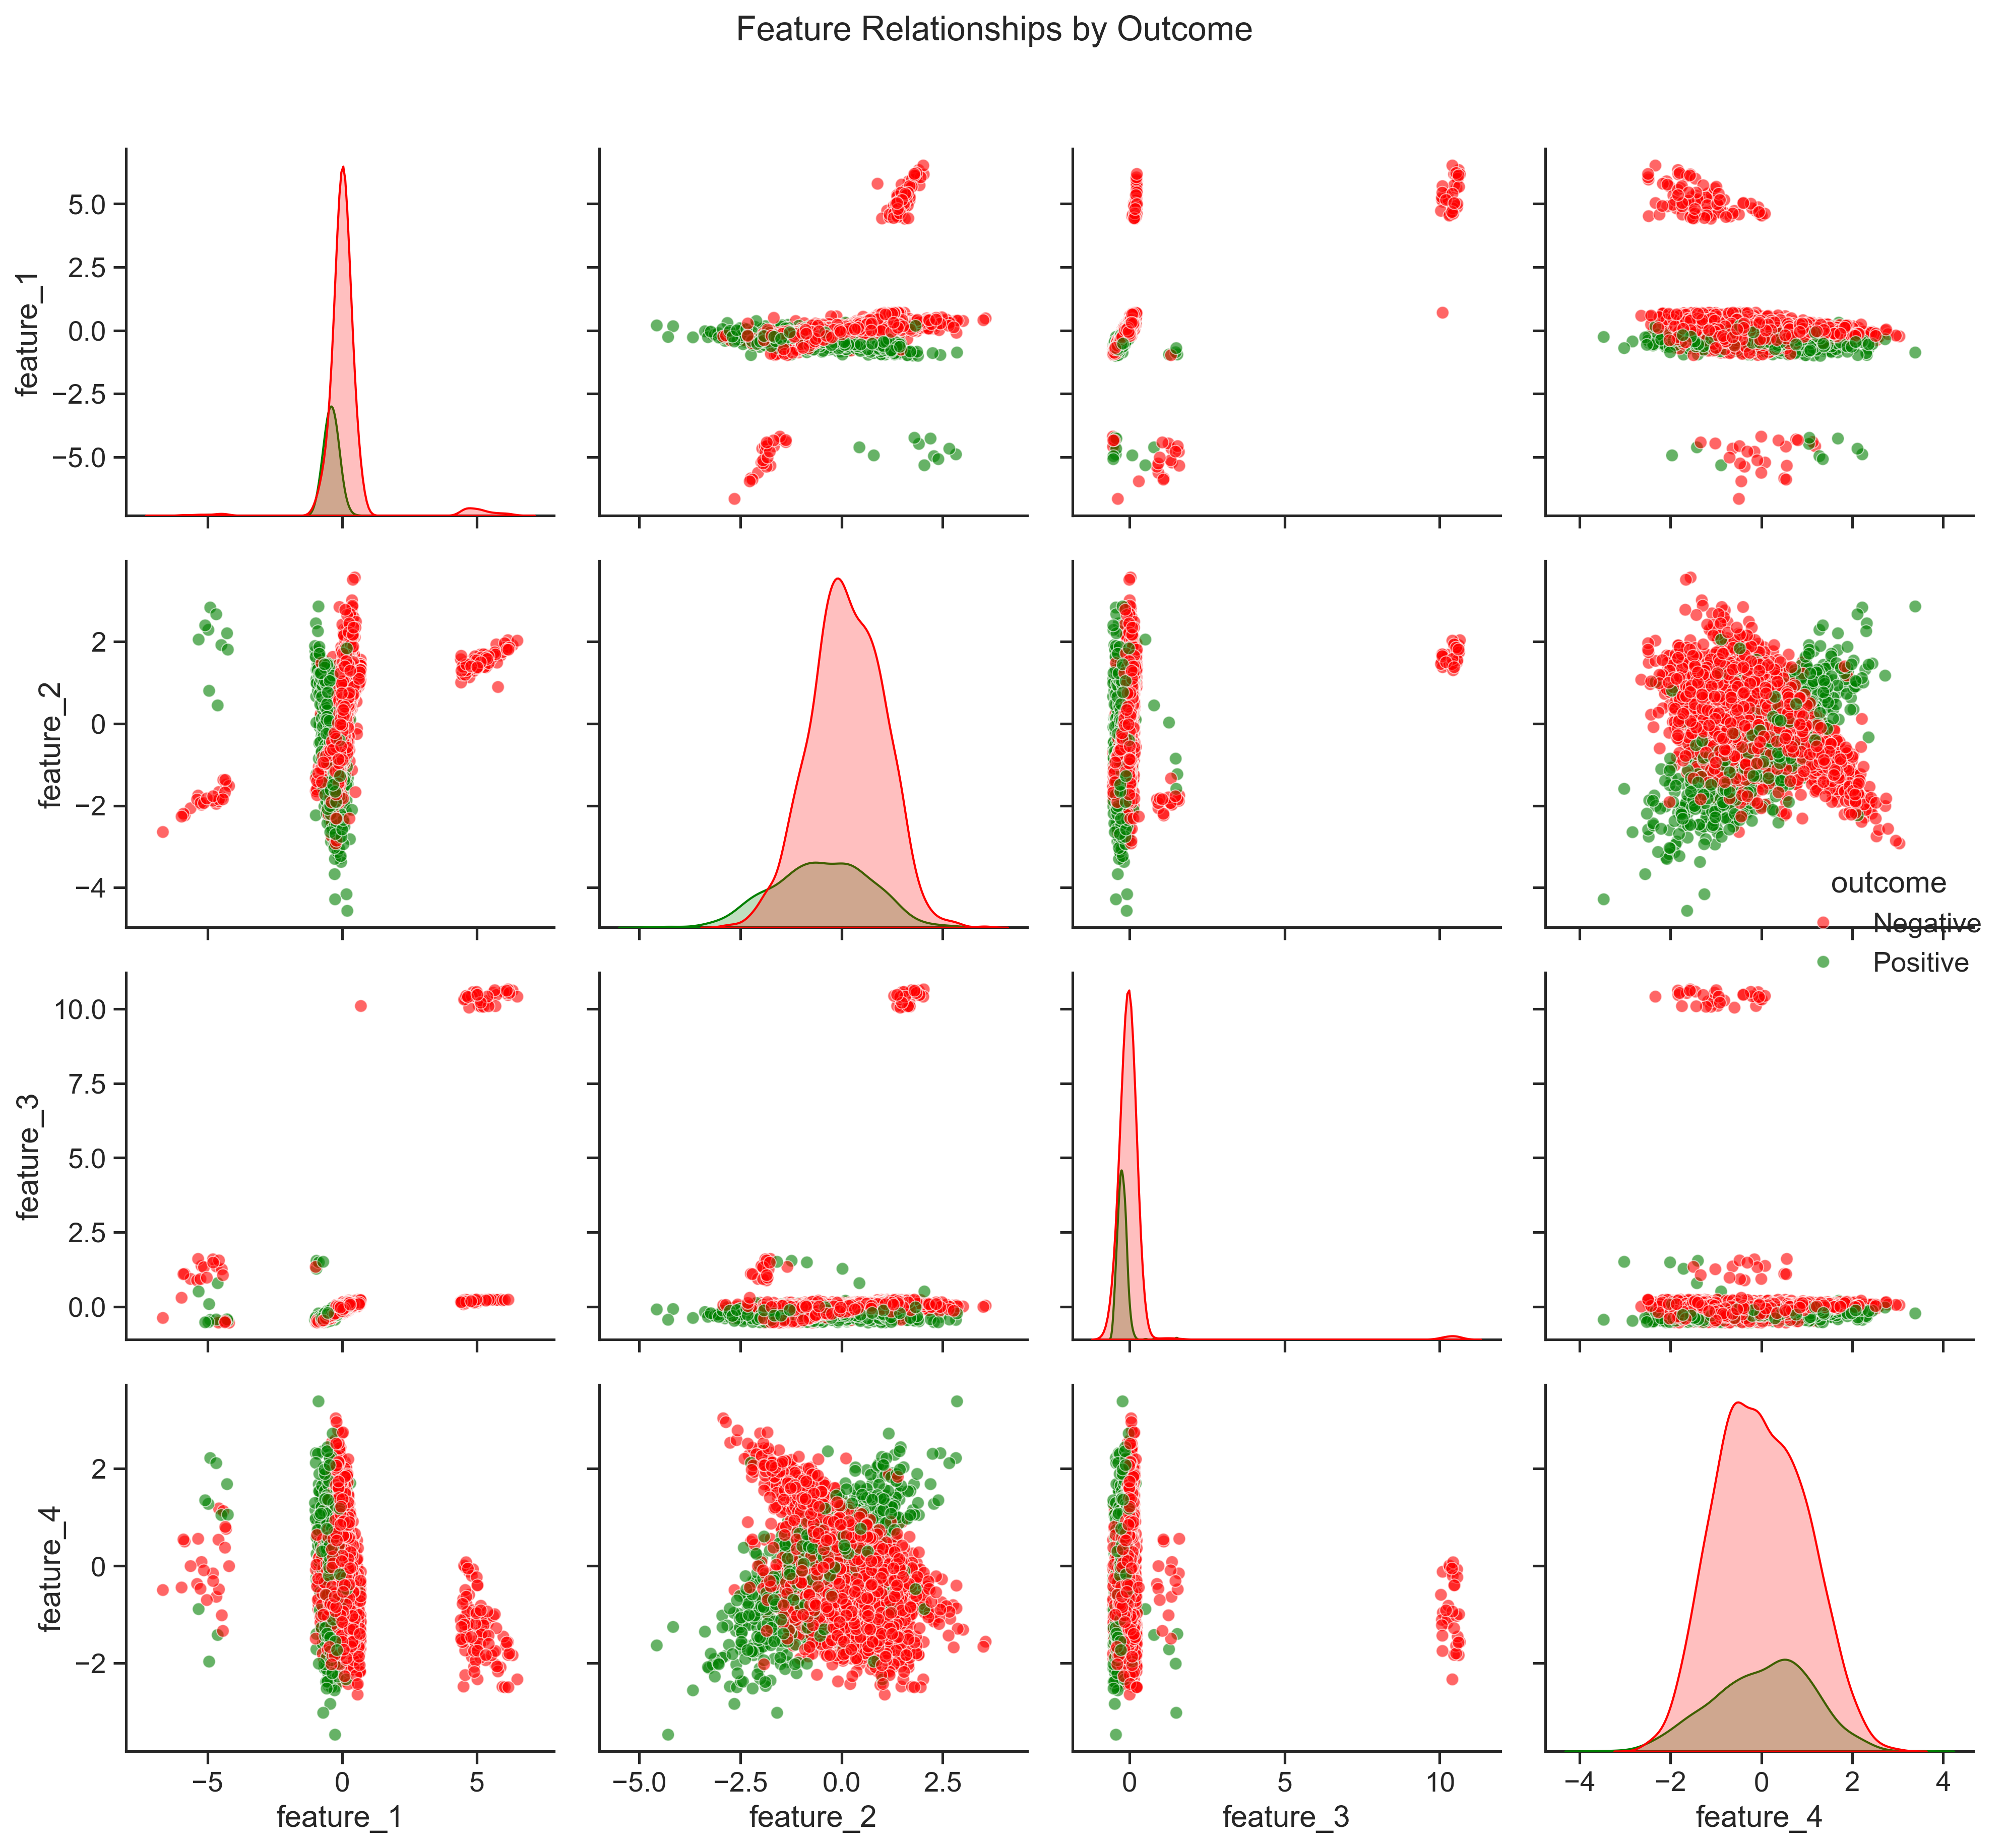

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
train['outcome'] = train['y'].map({1: 'Positive', 0: 'Negative'})

sns.set(style="ticks", font_scale=1.2)
plot = sns.pairplot(train[features + ['outcome']], 
                   hue='outcome',
                   palette={'Positive': 'green', 'Negative': 'red'},
                   plot_kws={'alpha': 0.6, 'linewidth': 0.5},
                   diag_kind='kde',
                   height=3)

plot.fig.suptitle('Feature Relationships by Outcome', y=1.02, size=16)
plt.tight_layout()
plt.show()

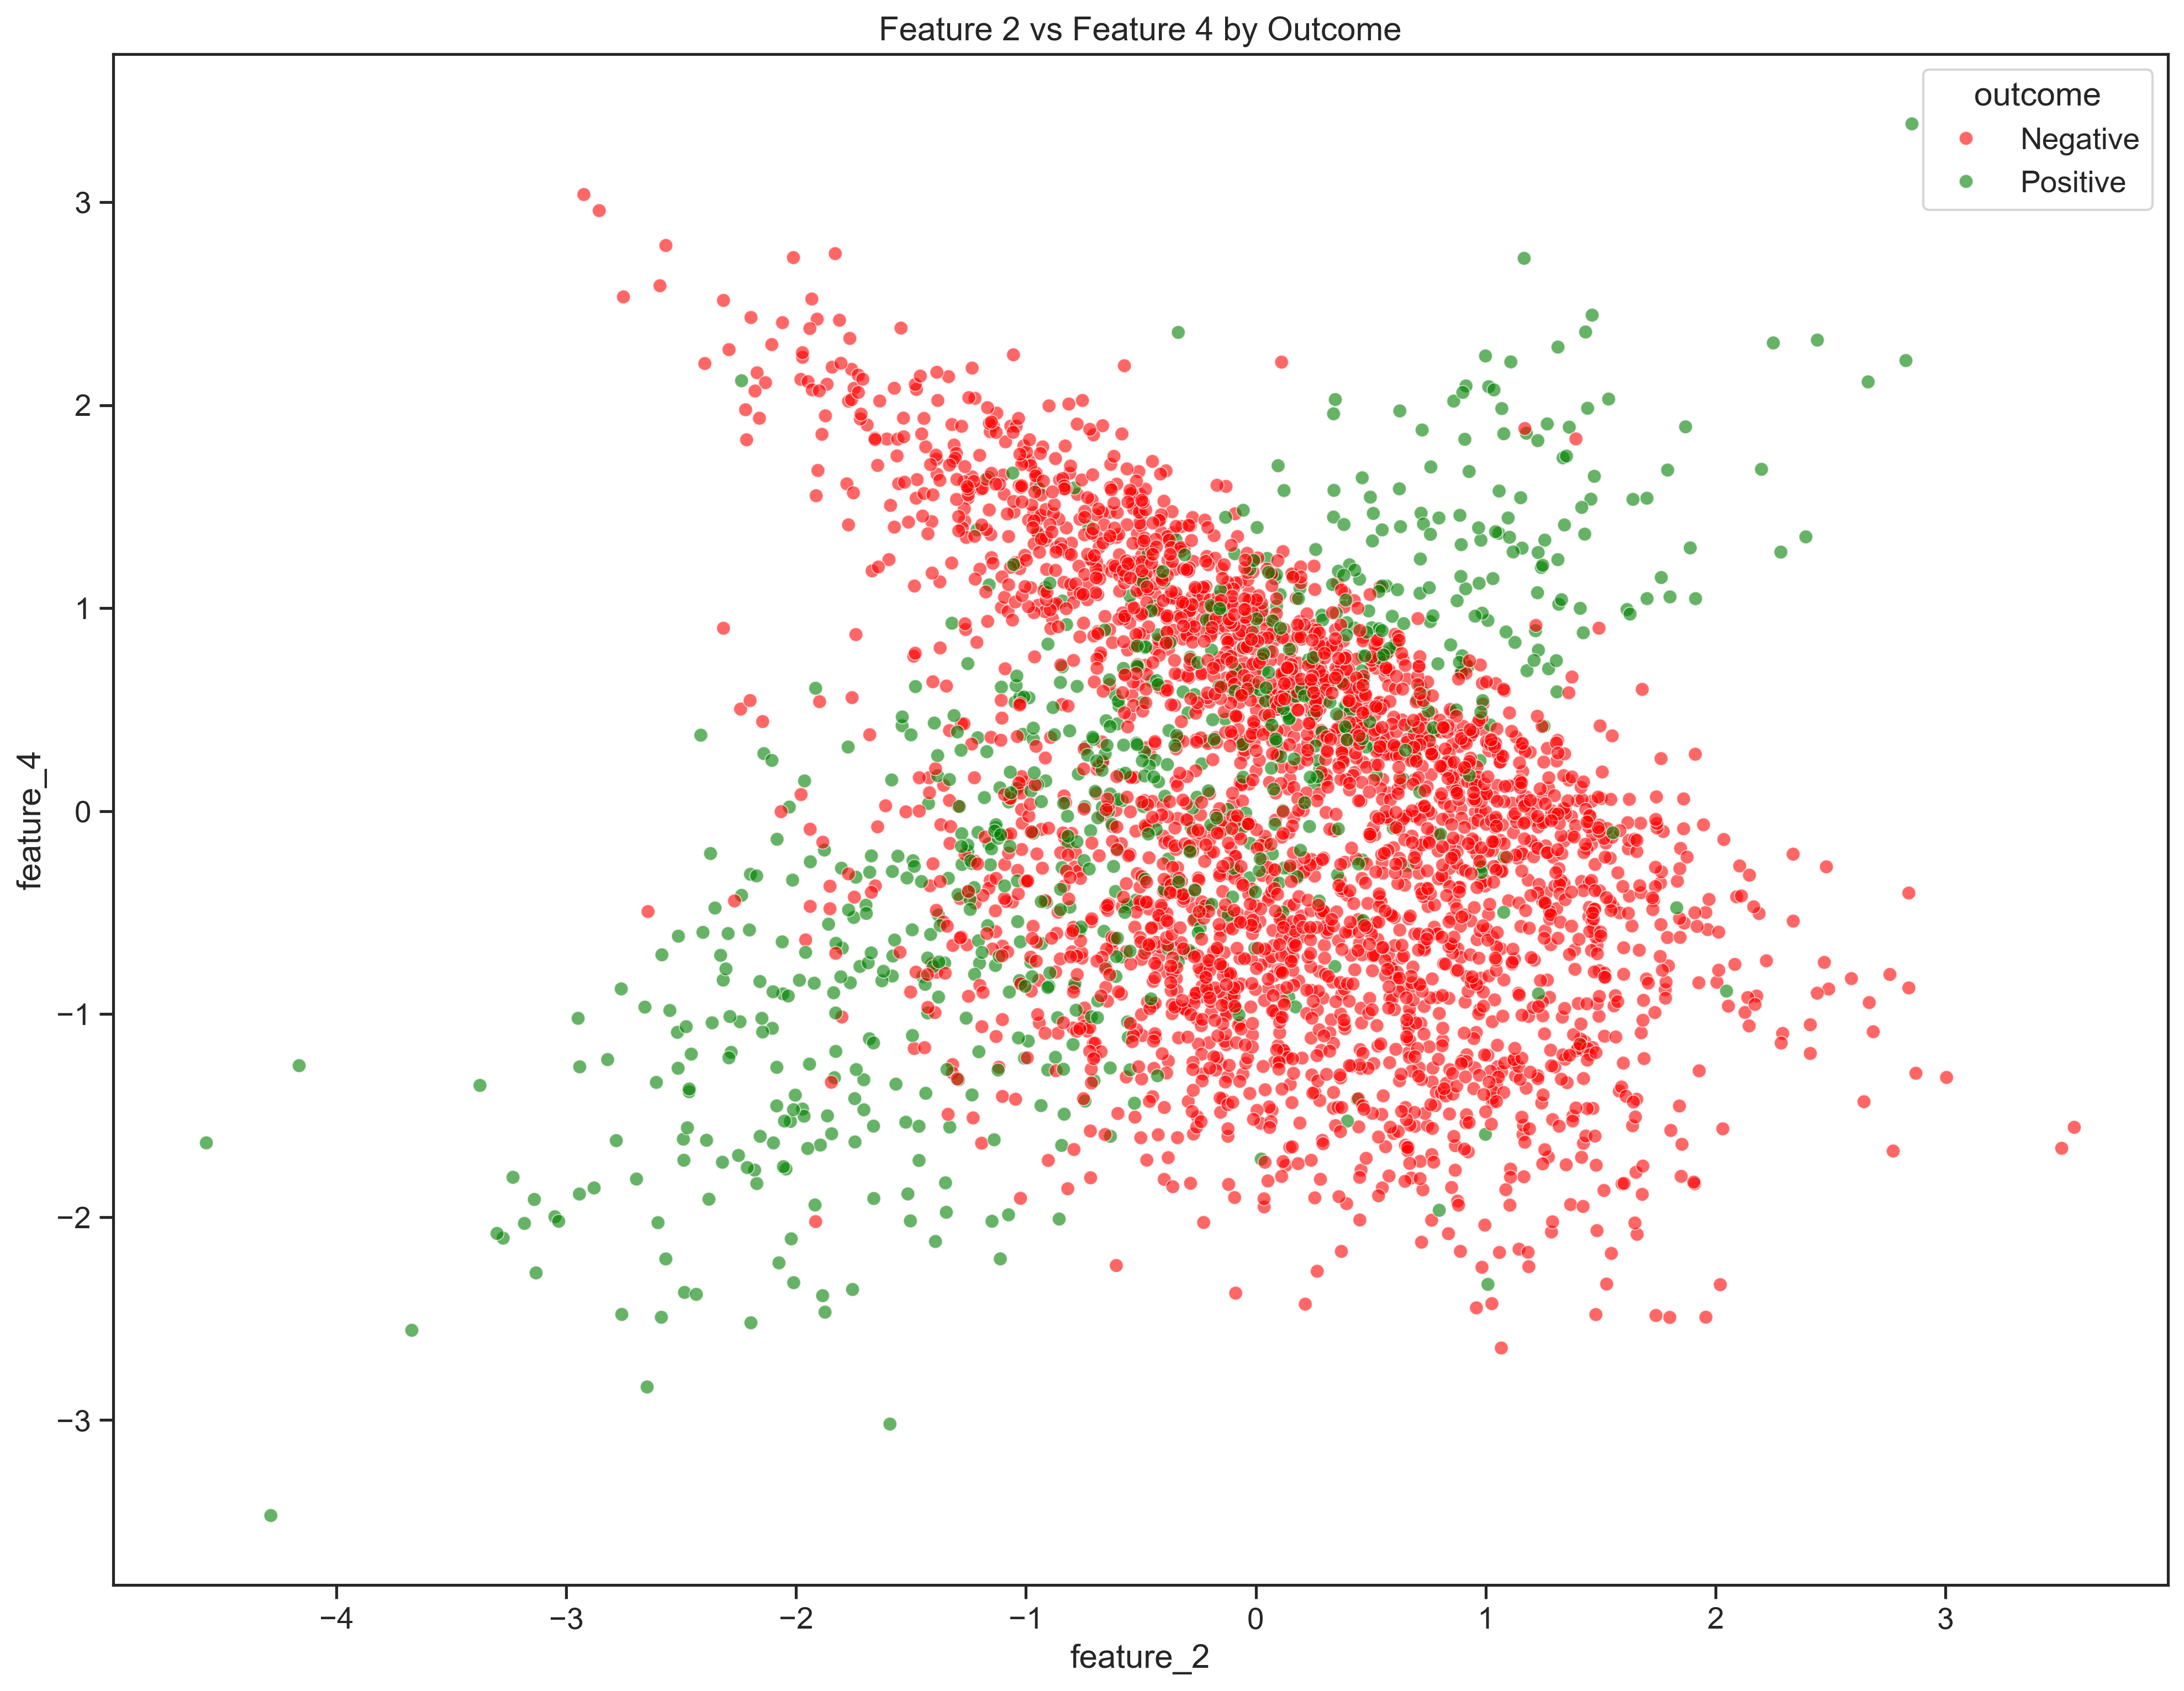

In [121]:
plt.figure(figsize=(16,12))
sns.scatterplot(data=train, x='feature_2', y='feature_4', hue='outcome', 
                palette={'Positive': 'green', 'Negative': 'red'}, alpha=0.6)
plt.title('Feature 2 vs Feature 4 by Outcome')
plt.show()

Optimization terminated successfully.
         Current function value: 0.277870
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.402580
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.458746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.365151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395740
         Iterations 9


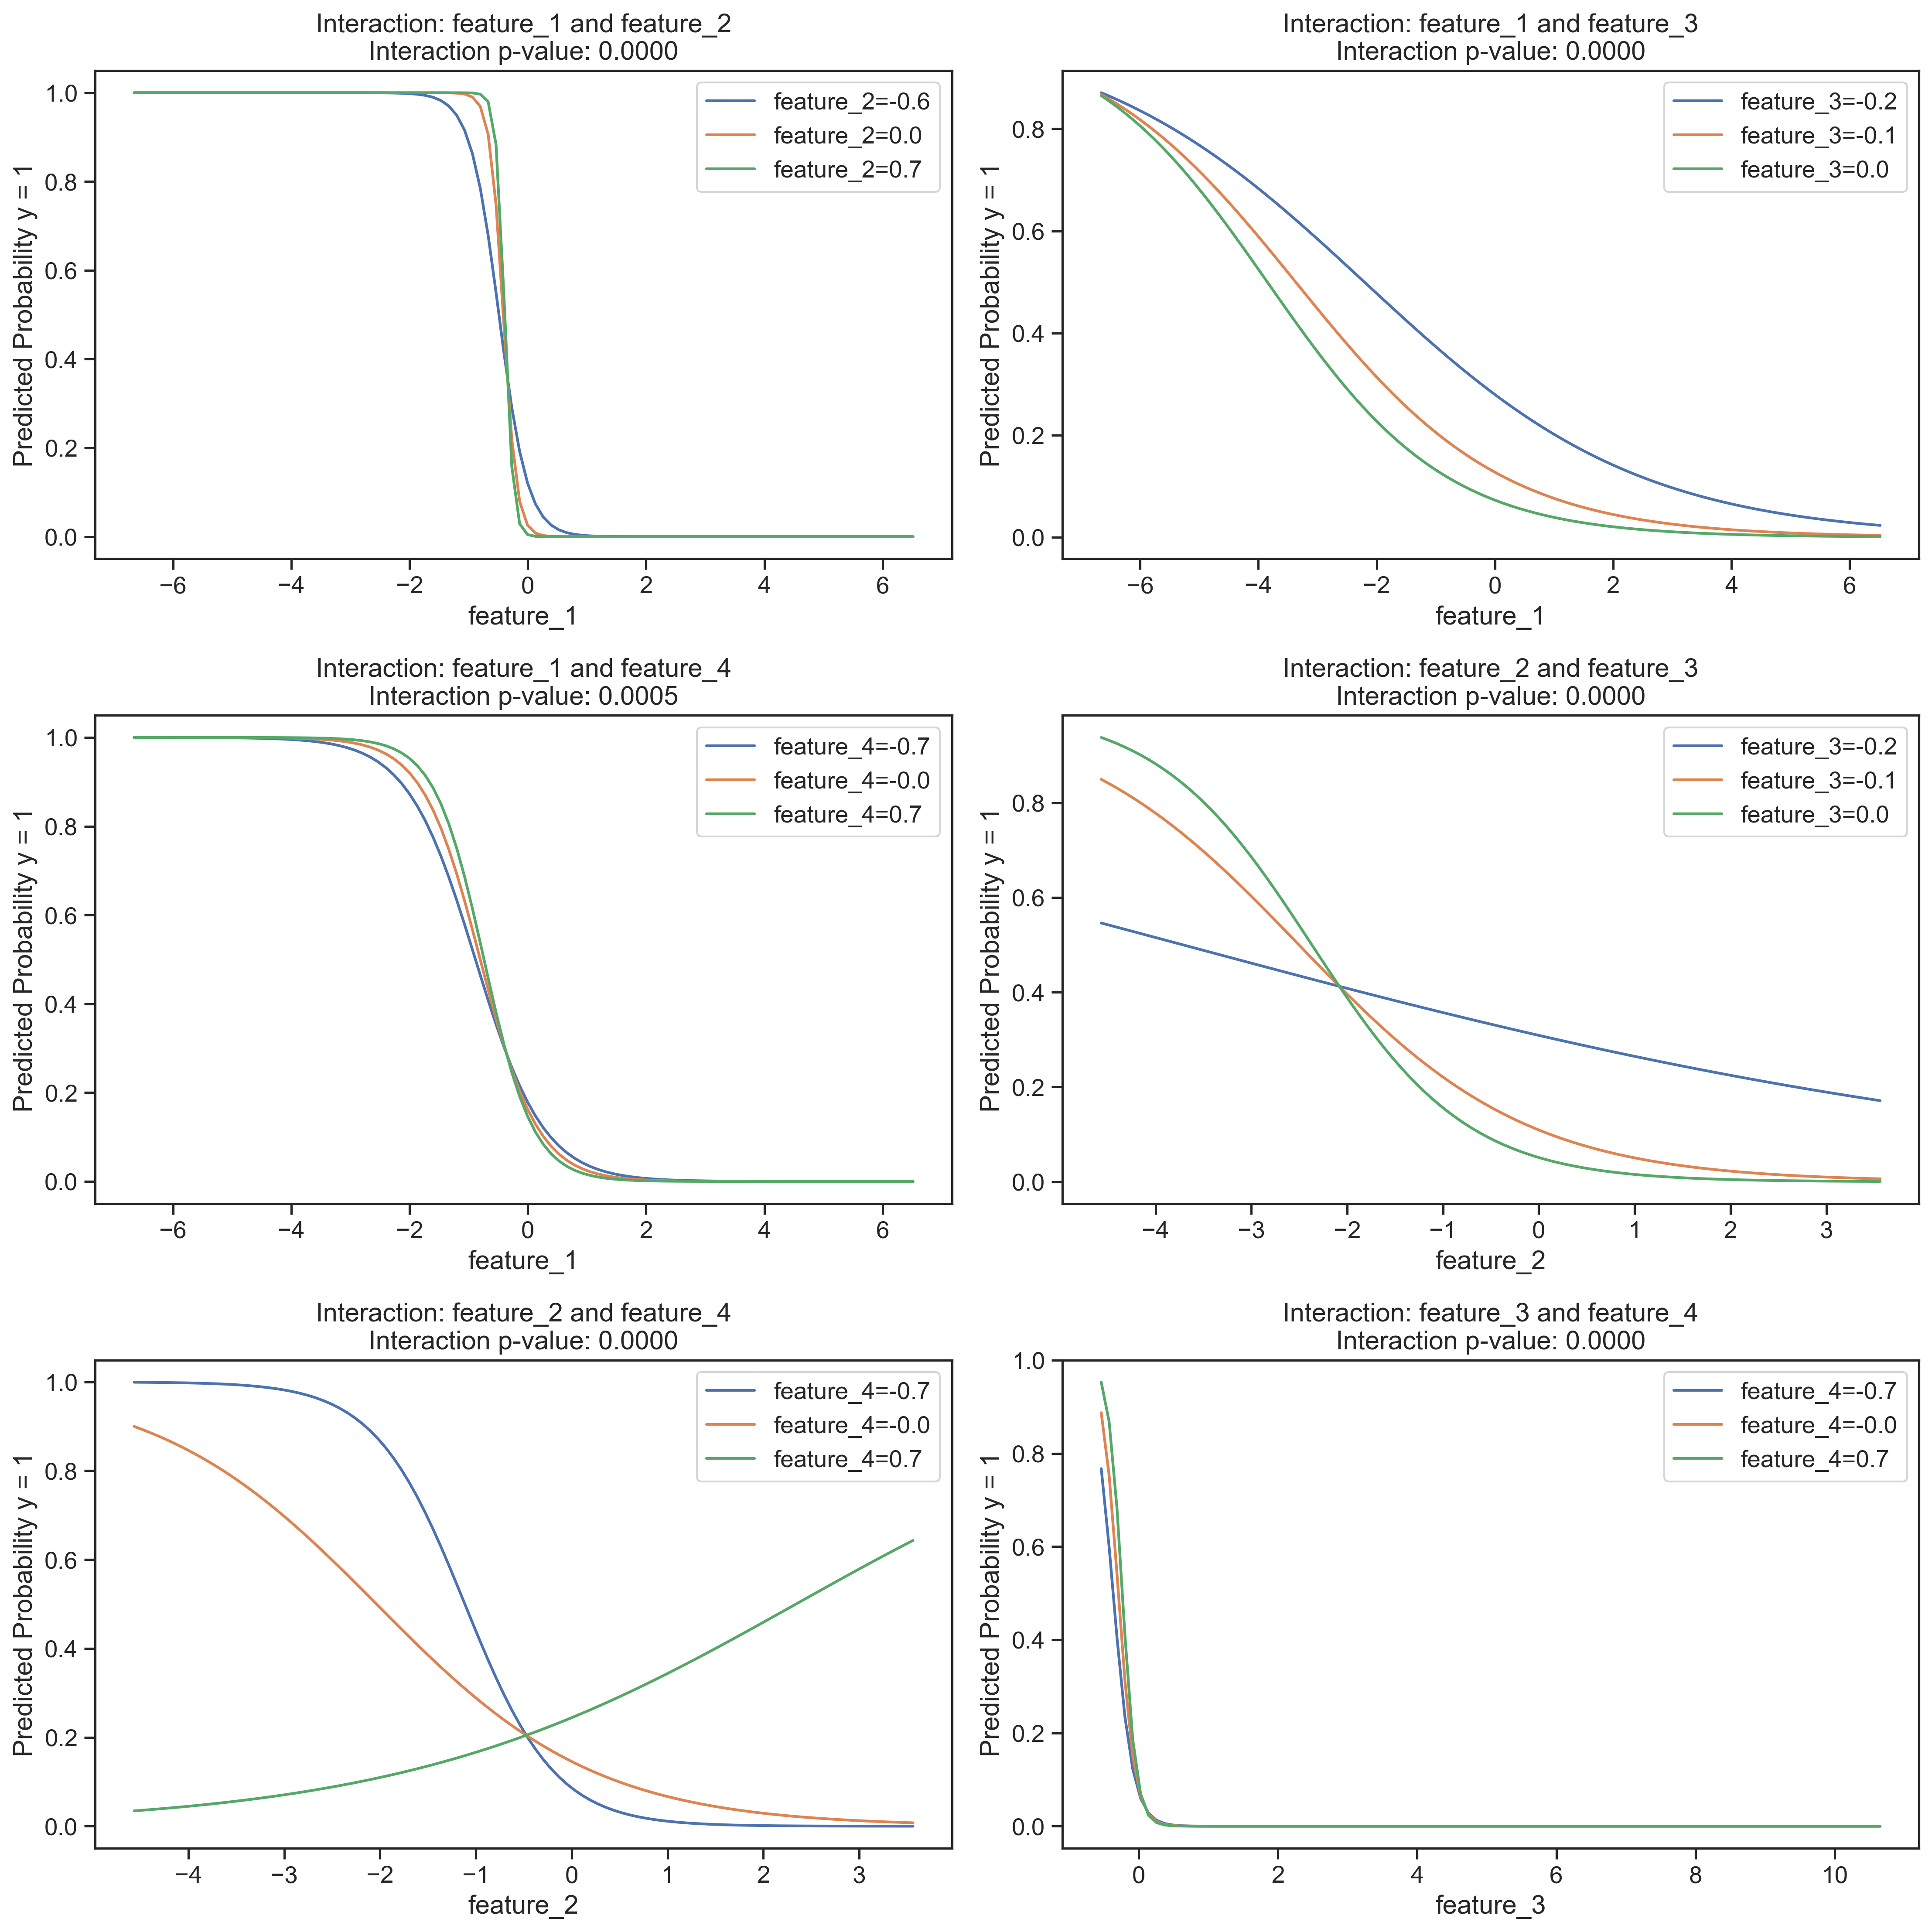


Significant interactions (p < 0.05):
feature_1 x feature_2
feature_1 x feature_3
feature_1 x feature_4
feature_2 x feature_3
feature_2 x feature_4
feature_3 x feature_4


In [122]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

variables = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

n_pairs = len(variables) * (len(variables) - 1) // 2
n_rows = (n_pairs + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()

significant_interactions = []
plot_idx = 0

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables[i+1:], i+1):
        formula = f'y ~ {var1} * {var2}'
        model = sm.Logit.from_formula(formula, data=train).fit()
        
        interaction_pvalue = model.pvalues[f'{var1}:{var2}']
        
        if interaction_pvalue < 0.05:
            significant_interactions.append((var1, var2))
        
        var1_values = np.linspace(train[var1].min(), train[var1].max(), 100)
        var2_levels = np.percentile(train[var2], [25, 50, 75])
        
        for var2_level in var2_levels:
            df = pd.DataFrame({
                var1: var1_values,
                var2: var2_level
            })
            df['interaction'] = df[var1] * df[var2]
            df['predicted_prob'] = model.predict(sm.add_constant(df))
            
            axes[plot_idx].plot(df[var1], df['predicted_prob'], 
                              label=f'{var2}={var2_level:.1f}')
        
        axes[plot_idx].set_xlabel(var1)
        axes[plot_idx].set_ylabel('Predicted Probability y = 1')
        axes[plot_idx].legend()
        axes[plot_idx].set_title(f'Interaction: {var1} and {var2}\nInteraction p-value: {interaction_pvalue:.4f}')
        plot_idx += 1

for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\nSignificant interactions (p < 0.05):")
for var1, var2 in significant_interactions:
    print(f"{var1} x {var2}")

add interaction terms to the model for features 2 and 4 and then see if an interaction term for features 2 and 3 matters 

# Random Forest Model 

In [123]:
from sklearn.ensemble import RandomForestClassifier
X_train = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y_train = train['y']
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train);

RF ROC Curve 

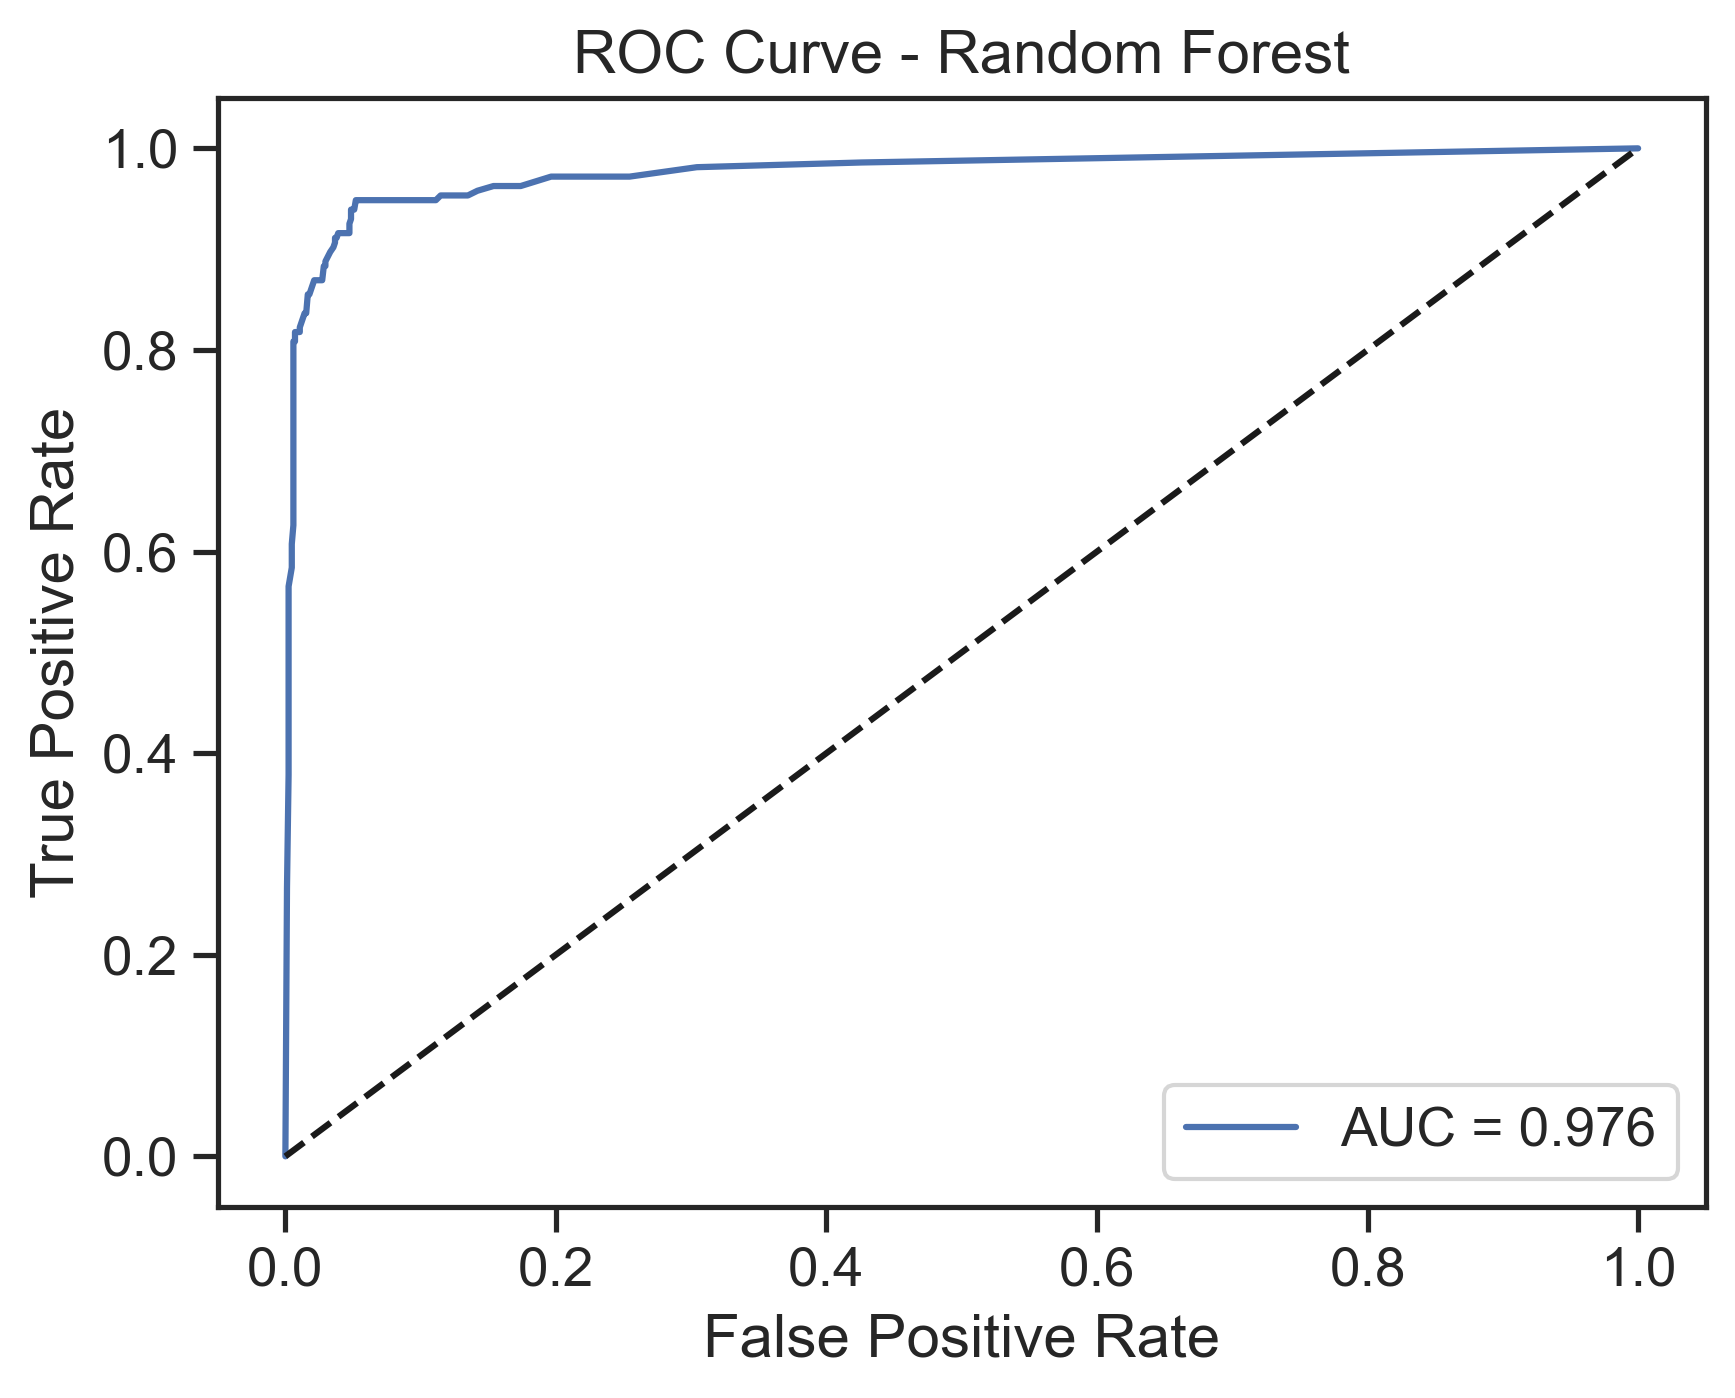

In [124]:
from sklearn.metrics import roc_auc_score
X_test = test[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y_test = test['y']

rf_pred_proba = rf_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, rf_pred_proba)
auc_score = roc_auc_score(y_test, rf_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend();

optimal threshold 

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, rf_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.240


recall at optimal threshold 

In [126]:
y_pred = (rf_pred_proba >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nRecall at optimal threshold: {recall:.3f}")

Confusion Matrix:
[[801  44]
 [ 11 203]]

Recall at optimal threshold: 0.949
